# Restricted Boltzmann Machines, MNIST

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import make_grid

## Set Helpers

In [20]:
def show_and_save(image, file_name, figsize=(10,10)):
    plt.figure(figsize=figsize)
    image = np.transpose(image.numpy(), (1, 2, 0))
    plt.imshow(image, cmap='gray')
    plt.savefig('./images/rbm_mnist.png')
    plt.show()

## Set Configs

In [3]:
BATCH_SIZE = 64
N_EPOCHS = 10
LR = 0.01
N_HID = 128
N_VIS = 784

## Set Data Loader

In [4]:
transform = transforms.Compose([transforms.ToTensor()])
dataset = torchvision.datasets.MNIST('./data', train=True, download=True, transform=transform)

In [5]:
train_loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=BATCH_SIZE)

In [6]:
# decide which device we want to run on
device = torch.device('cuda:0' if (torch.cuda.is_available() and n_gpu > 0) else 'cpu')

## Build [RBM](http://proceedings.mlr.press/v5/salakhutdinov09a/salakhutdinov09a.pdf) Architecture

In [7]:
class RBMNet(nn.Module):
    """
    Restricted Boltzmann Machine Network.
    Args:
        n_vis (int, optional): The size of visible layer. Defaults to 784.
        n_hid (int, optional): The size of hidden layer. Defaults to 128.
        k (int, optional): The number of Gibbs sampling. Defaults to 1.
    """
    
    def __init__(self, n_vis=N_VIS, n_hid=N_HID, k=1):
        super(RBMNet, self).__init__()
        self.v = nn.Parameter(torch.randn(1, n_vis))
        self.h = nn.Parameter(torch.randn(1, n_hid))
        self.W = nn.Parameter(torch.randn(n_hid, n_vis))
        self.k = k
        
    def visible_to_hidden(self, v):
        p = torch.sigmoid(F.linear(v, self.W, self.h))
        return p.bernoulli()
    
    def hidden_to_visible(self, h):
        p = torch.sigmoid(F.linear(h, self.W.t(), self.v))
        return p.bernoulli()
    
    def free_energy(self, v):
        v_term = torch.matmul(v, self.v.t())
        w_x_h = F.linear(v, self.W, self.h)
        h_term = torch.sum(F.softplus(w_x_h), dim=1)
        
        return torch.mean(-h_term - v_term)
    
    def forward(self, v):
        h = self.visible_to_hidden(v)
        for _ in range(self.k):
            v_gibb = self.hidden_to_visible(h)
            h = self.visible_to_hidden(v_gibb)
            
        return v, v_gibb

#### Initialize RBM Network

In [8]:
rbm = RBMNet().to(device)

## Set Optimizer

In [9]:
optimizer = torch.optim.Adam(rbm.parameters(), lr=LR)

## Train The RBM Network

In [10]:
train_loss_history = []
N = len(dataset)
rbm.train()
for epoch in range(1, N_EPOCHS+1):
    train_loss = 0
    for _, (image, target) in enumerate(train_loader):
        
        optimizer.zero_grad()
        
        v, v_gibbs = rbm(image.view(-1, 784))
        loss = rbm.free_energy(v) - rbm.free_energy(v_gibbs)
        
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
    train_loss = train_loss/(N//BATCH_SIZE)
    train_loss_history.append(train_loss)
    print('Epoch: %d, loss: %.7f' % (epoch, train_loss))

Epoch: 1, loss: 37.9739874
Epoch: 2, loss: -1.3857882
Epoch: 3, loss: -0.8236033
Epoch: 4, loss: -0.0871355
Epoch: 5, loss: 0.4103965
Epoch: 6, loss: 0.6101028
Epoch: 7, loss: 0.8733566
Epoch: 8, loss: 1.2082245
Epoch: 9, loss: 1.4242106
Epoch: 10, loss: 1.5266941


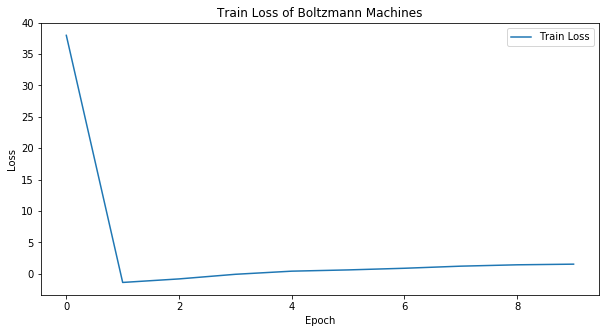

In [11]:
plt.figure(figsize=(10,5))
plt.title("Train Loss of Boltzmann Machines")
plt.plot(train_loss_history, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

if not os.path.exists('./images/'): os.makedirs('./images/')
plt.savefig('./images/final_train_loss_mnist.png')
plt.show()

## Test The RBM Network

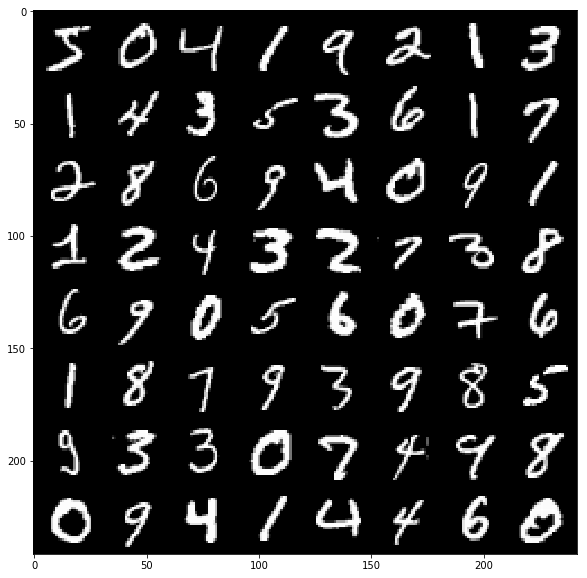

In [21]:
images = next(iter(train_loader))[0]
v, v_gibbs = rbm(images.view(-1, 784))
show_and_save(make_grid(v.view(BATCH_SIZE, 1, 28, 28).data), './images/real_images.png')

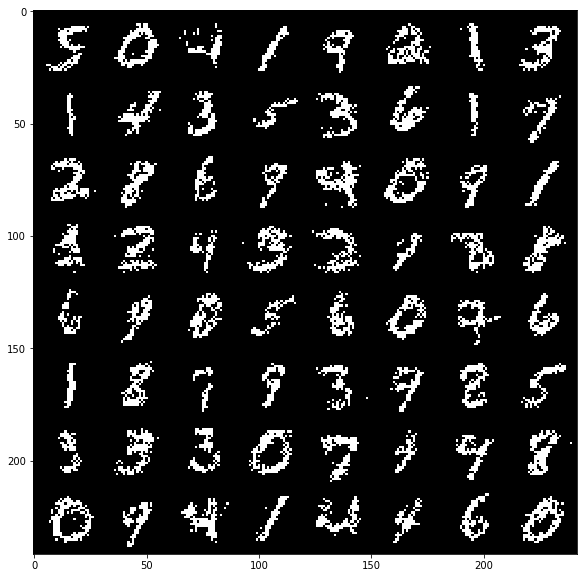

In [22]:
show_and_save(make_grid(v_gibbs.view(BATCH_SIZE, 1, 28, 28).data), './images/generated_images.png')

#### Look at images factorized through the hidden variables

In [24]:
n_sample = 4
kth = 18
d = images[kth:kth+1]

V = torch.sigmoid(F.linear(d.view(1, -1), rbm.W, rbm.h))
v, o = torch.sort(V.view(-1))

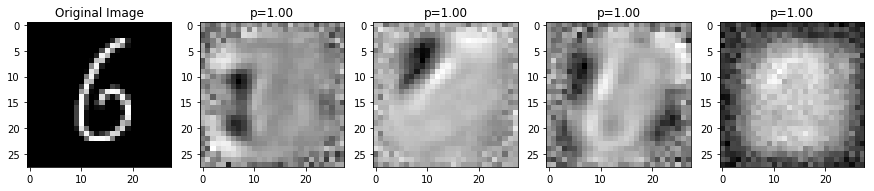

In [25]:
fig, ax = plt.subplots(1, n_sample+1, figsize=(3*(1 + n_sample), 3))
ax[0].imshow(d.view(28,28).numpy(), cmap='gray')
ax[0].set_title('Original Image')

for k, i in enumerate(o[-n_sample:].numpy()):
    factorized = rbm.W[i].view(28,28).data.numpy()
    ax[k+1].imshow(factorized, cmap='gray')
    ax[k+1].set_title('p=%.2f'% V[0][i].item())
    
plt.savefig('./images/factorized.png', dpi=200)

---